# Representation of signals & inverse problems - G1-G2
---
## Lab 2: Wavelet transform and image processing

---
## Guidelines (read carefully before starting)

**Objective**: this lab explores some aspects of orthogonal wavelet transforms in 2D for image processing, with applications to denoising and filtering. All the numerical illustrations covered in this session rely on the Python module `Pywavelets`.

Each wavelet is determined by its low-pass filter or scaling function (in french _fonction d'échelle_). The longer this filter (*i.e.*, the more coefficients it contains), the larger the number of null moments. For instance, Daubechies wavelets are composed of $p=2k$ coefficients, for $k$ null moments.

A larger number of null moments allows regular signals/images to be better compressed. However, an extended support of the wavelet can be problematic to represent highly irregular regions of the signal, such as discontinuities.

The choice of a wavelet is a matter of compromise, depending on the type of structures expected to be observed in the image of interest.

**Guidelines**: after retrieving the resources for the lab on moodle:
- place the .zip archive in a local folder (Computer -> Documents/Python/);
- unzip the archive .zip;
- rename the folder with the convention lab2_Name1_Name2;
- duplicate the notebook file and rename it lab2_Name1_Name2.ipynb;
- at the end of the session, do not forget to transfer your work to your own network space if you are working on a machine from the school (do not leave your work on the C: drive).

**Assessment** &#8594; global grade from F to A (A+)

Assessmment based on your answer to the exercises reported in the notebook and any additional `.py` file produced. Custom code should be commented whenever appropriate. Figures should be clearly annotated (axes, title).

1. Numerical correctness
2. Implementation clarity (documentation, relevance of the comments)
3. Answers to the questions and overall presentation of the Jupyter notebook.

## Configuration

In [36]:
# make sure the notebook reloads the module each time we modify it
%load_ext autoreload
%autoreload 2

# Uncomment the next line if you want to be able to zoom on plots (one of the options below)
# %matplotlib widget
# %matplotlib notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pywt
import scipy.signal as sg
from IPython.display import Audio
from lib.plotwavelet import plot_wavelet, psnr
from matplotlib.colors import LogNorm  # for Log normalization

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Contents <a id="content"></a>

1. [1D discrete wavelet transform](#section1)
   - [Exercise 1](#ex1)
2. [2D discrete wavelet transform](#section2)
   - [Exercise 2](#ex2) 
3. [Wavelet filtering](#section3)
   - [Exercise 3](#ex3) 
4. [Wavelet denoising](#section4)
   - [Exercise 4](#ex4) 
   - [Bonus: Exercise 5](#ex5)

---
## 1D discrete wavelet transform <a id="section1"></a> [(&#8593;)](#content)

[PyWavelets](https://pywavelets.readthedocs.io/en/latest/ref/index.html) (`pywt`) is an open source wavelet transform package for Python. It combines a simple high level interface with low level C and Cython performance. 

The Discrete Wavelet Transform (DWT) of a signal can be computed with the `pywt.dwt` and `pywt.wavedec` functions (see the example below). The result is stored in a dictionary of arrays containing each octave separately, as well as the approximation level. 

An example of application to a chirp signal is reported below, illustrating the multiresolution analysis of a wideband signal.

In [38]:
N = 2**13
Fs = 1024
t = np.arange(0, N, 1) / Fs
x = sg.chirp(t, f0=60, f1=2, t1=10, method="hyperbolic")

Audio(x, rate=44 * Fs)  # artificially change Fs for listening purposes

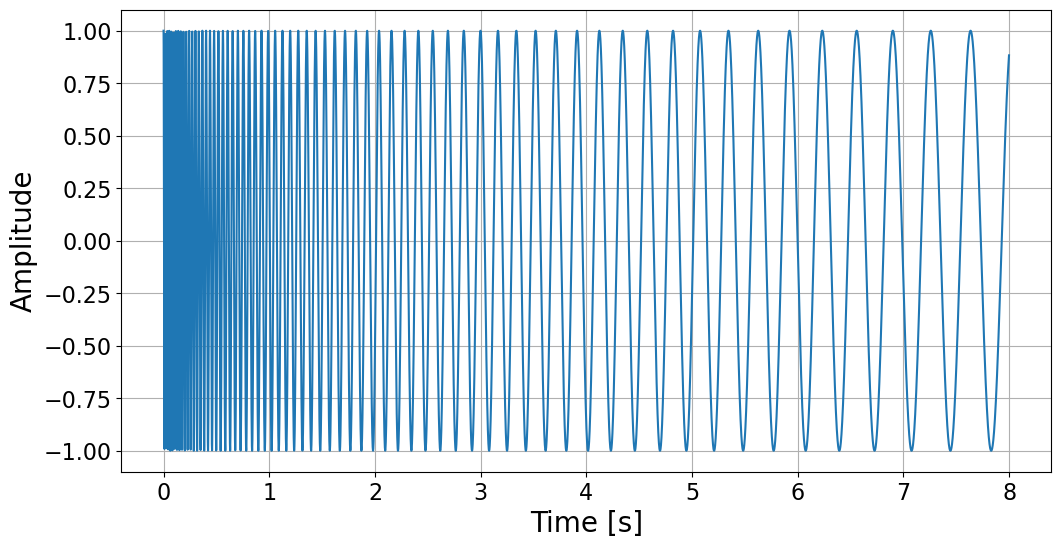

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(t, x)
plt.xlabel("Time [s]")
plt.ylabel(r"Amplitude")
plt.grid()
plt.show()

Different wavelets are available. Use the `pywt.wavelist()` command to display the list of the available built-in wavelets.

In [78]:
#pywt.wavelist() # uncomment to run the command

print(pywt.wavelist(kind='discrete'))

['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 'sym16', 'sym17', 'sym18', 'sym19', 'sym20']


#### Computing your first orthogonal wavelet transform
The function `pywt.dwt` computes the wavelet transform for a single decomposition level, returning the corresponding approximation coefficients and details.

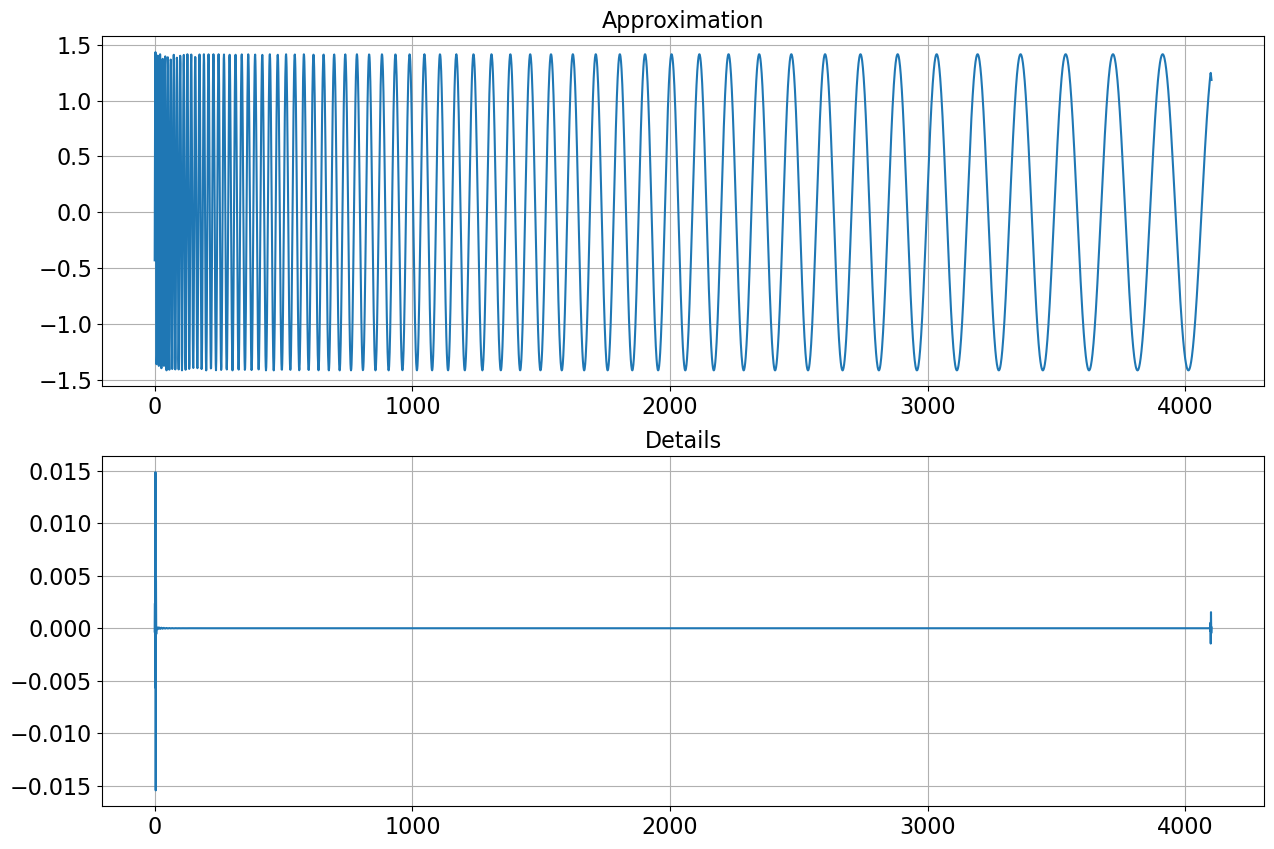

In [41]:
cA, cD = pywt.dwt(x, "sym8")

plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(cA)
plt.title("Approximation")
plt.grid()

plt.subplot(212)
plt.plot(cD)
plt.title("Details")
plt.grid()
plt.show()

The `pywt.wavedec` function computes a multi-level wavelet transform. It returns an ordered list of coefficients arrays, where `level` denotes the number of decomposition levels. Wavelet coefficients are stored in an object `coeff`. The first element `coeff[0]` is an array containing approximation coefficients. The following elements `coeff[i]` are arrays containing the details coefficients at the different scales.

In [42]:
level = 7
coeff = pywt.wavedec(x, "sym8", level=level)

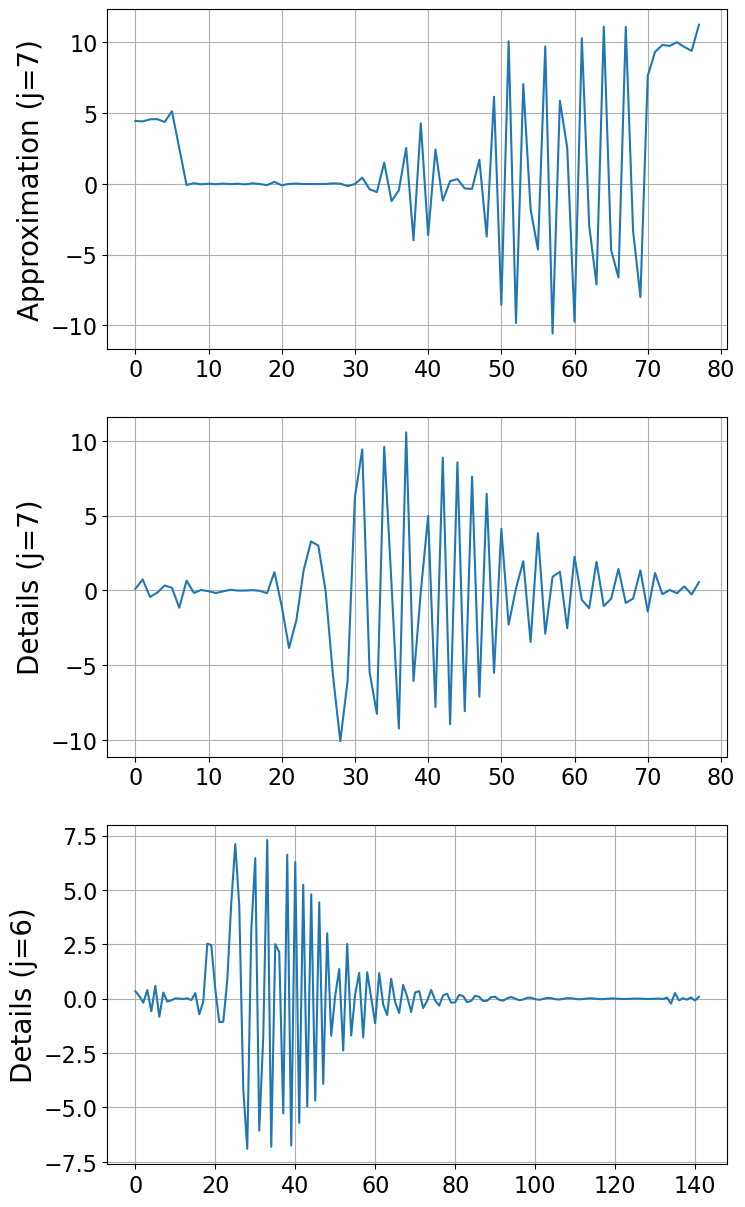

In [43]:
plt.figure(figsize=(8, 15))
plt.subplot(311)
plt.plot(coeff[0])
plt.ylabel("Approximation (j={})".format(level))
plt.grid()
plt.subplot(312)
plt.plot(coeff[1])
plt.ylabel("Details (j={})".format(level))
plt.grid()
plt.subplot(313)
plt.plot(coeff[2])
plt.ylabel("Details (j={})".format(level - 1))
plt.grid()
plt.show()

### Exercise 1 <a id="ex1"></a> [(&#8593;)](#content)
1. Read the documentation of the functions `pywt.dwt`, `pywt.idwt` and `pywt.wavedec`. What are these functions used for? What is the difference between these functions?
2. The smallest scales can be filtered out by setting the associated wavelet coefficients to zero. Illustrate the effect of setting to 0 coefficients of the details (or the approximation) for a given set of octaves.
_Indication: to do this, you need to compute the wavelet transform, set some coefficients to zero and then reconstruct the signal by using the inverse wavelet transform._
3. Try this filtering operation with several wavelets of your choice and compare the results. Observe and comment.
4. Use at least one other 1D signal using `pywt.data`, and repeat the operations described in 2. and 3.

<p style="color:rgb(137, 207, 240);">Your comments</p>

In [44]:
# Your codes #

1.

pywt.dwt : single level discrete wavelet transform

pywt.idwt : single level inverse discrete wavelet transform

pywt.wavedec : performs multilevel discrete wavelet transform decomposition

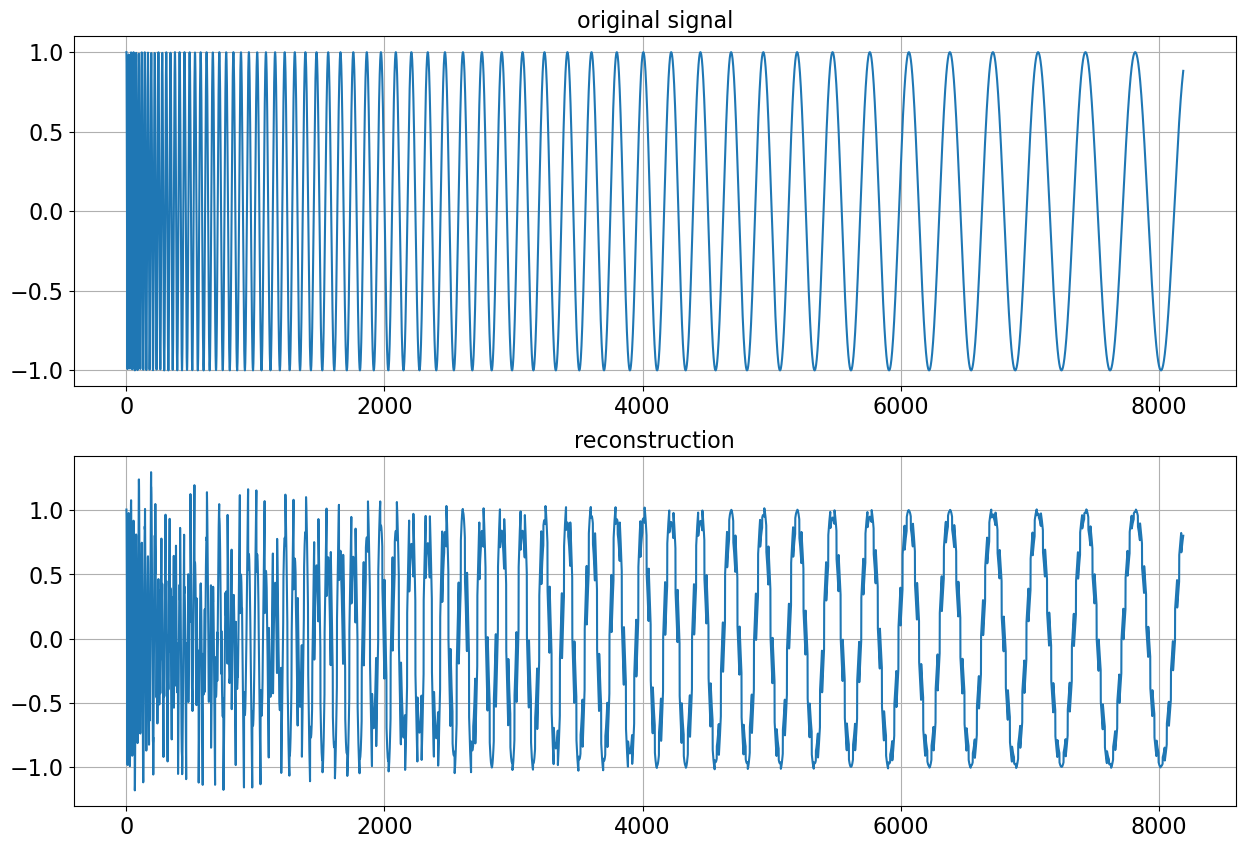

In [80]:
# 2 and 3
'''
cA, cD = pywt.dwt(x, "sym8")

cD[:] = 0
    
x_new = pywt.idwt(cA, cD, "sym8")
    
'''
#coeffs = pywt.wavedec(x, 'coif10', level=5)
coeffs = pywt.wavedec(x, 'bior1.1', level=5)

#[cAn, cDn, cDn-1, ..., cD2, cD1]
coeffs[1][:] = 0

#x_new = pywt.waverec(coeffs, 'coif10')
x_new = pywt.waverec(coeffs, 'bior1.1')

plt.figure(figsize=(15, 10))

plt.subplot(211)
plt.plot(x)
plt.title("original signal")
plt.grid()

plt.subplot(212)
plt.plot(x_new)
plt.title("reconstruction")
plt.grid()
plt.show()


---
## 2D discrete wavelet transform <a id="section2"></a> [(&#8593;)](#content)
We now turn to the computation of a 2D wavelet transform to analyze images (example images are available in the `img/` folder). Let us start with a simple chessboard image.

_Indication: you can consider other images, in particular using `pywt.data`._

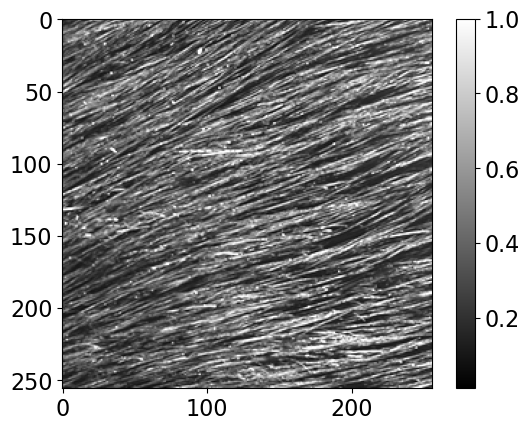

In [114]:
filename = "img/hair.png"
#filename = "img/chessboard.png"

I = mpimg.imread(filename)

plt.figure()
plt.imshow(I, cmap="gray")
plt.colorbar()
plt.show()

#### Wavelet transform
We first compute a 2D wavelet transform using the function `pywt.wavedec2` and display the results.

In [147]:
# Wavelet decomposition
Jmax = int(np.log2(I.shape[0]))  # maximal number of octaves
J = 1

#wtcoeffs = pywt.wavedec2(I, wavelet="sym8", level=J, mode="periodization")
wtcoeffs = pywt.wavedec2(I, wavelet="haar", level=J, mode="periodization")

Since the coefficients are stored in a dictionary of objects, we need to convert these into an array for obtain a graphical representation using the `plot_wavelet` function.

array([[0.69917744, 0.70622796, 0.70857811, ..., 0.49421963, 0.50867051,
        0.49132949],
       [0.69917744, 0.70387775, 0.71210337, ..., 0.50000006, 0.49132949,
        0.49421966],
       [0.6980024 , 0.69330198, 0.70035255, ..., 0.50289017, 0.51445085,
        0.49132946],
       ...,
       [0.50585932, 0.53515619, 0.46679685, ..., 0.5666666 , 0.44761908,
        0.5380953 ],
       [0.45703125, 0.46484375, 0.55664062, ..., 0.54285711, 0.47619048,
        0.38571432],
       [0.4902344 , 0.49218744, 0.50195307, ..., 0.47619048, 0.49047622,
        0.16666669]])

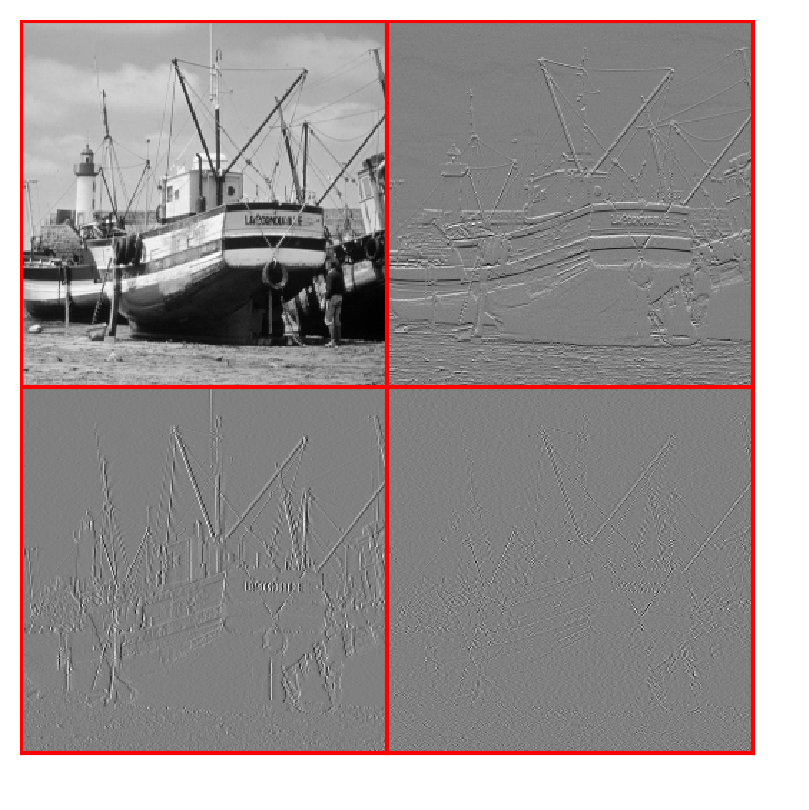

In [148]:
# Casting coeff in a single array
wtcoeffs_arr, coeff_slices = pywt.coeffs_to_array(wtcoeffs)

# Graphical representation
plt.figure(figsize=(5, 5), dpi=200)
plot_wavelet(wtcoeffs_arr, Jmin=Jmax - J)

## Exercise 2 <a id="ex2"></a> [(&#8593;)](#content)
1. Observe the figure above and briefly recall its structure and what it represents.
2. Play with the parameter $J$ (corresponding to the optional parameter `level` from `pywt.wavedec2`). What does it correspond to?
3. Observe the wavelet transform of other images.
4. For the checkerboard image, try the Haar wavelet and compare the result with any other wavelet transform. What do you notice? Do you have an explanation?

<p style="color:rgb(137, 207, 240);">Your comments</p>

In [149]:
# Your codes #

**Remark:** a 2D wavelet transform is a succession of two 1D DWT. Using only 1 step of the multiresolution hierarchy, one obtains the following result.

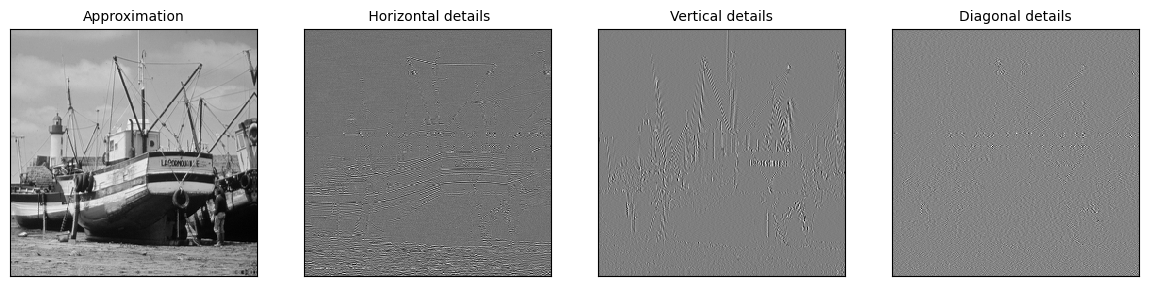

In [150]:
coeffs2 = pywt.dwt2(I, "sym8")

LL, (LH, HL, HH) = coeffs2

fig = plt.figure(figsize=(12, 3))
titles = [
    "Approximation",
    " Horizontal details",
    "Vertical details",
    "Diagonal details",
]
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

---
## Wavelet filtering <a id="section3"></a> [(&#8593;)](#content)
This section illustrates a filtering procedure conducted in the wavelet domain. The purpose is to observe that one can filter an image both at a given scale, for specific orientations, and at chosen places on top.

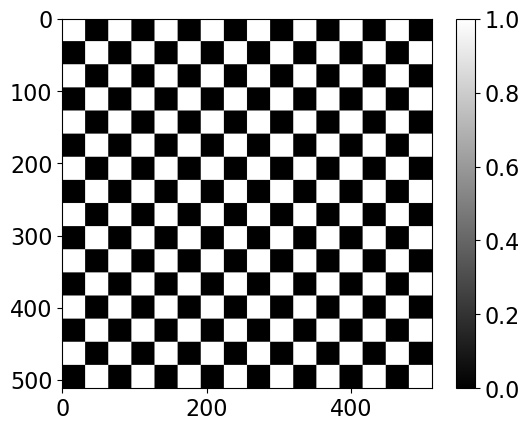

In [151]:
filename = "img/chessboard.png"
I = mpimg.imread(filename)


plt.figure()
plt.imshow(I, cmap="gray")
plt.colorbar()
plt.show()

#### First steps for filtering
We will first use a 1 step decomposition and put some coefficients to zero.

In [152]:
coeffs2 = pywt.dwt2(I, "db4")

In [153]:
LL, (LH, HL, HH) = coeffs2

In [154]:
L = 8
LL[2 ** (L - 1) : 2**L + 1, 2 ** (L - 1) : 2**L + 1] = 0

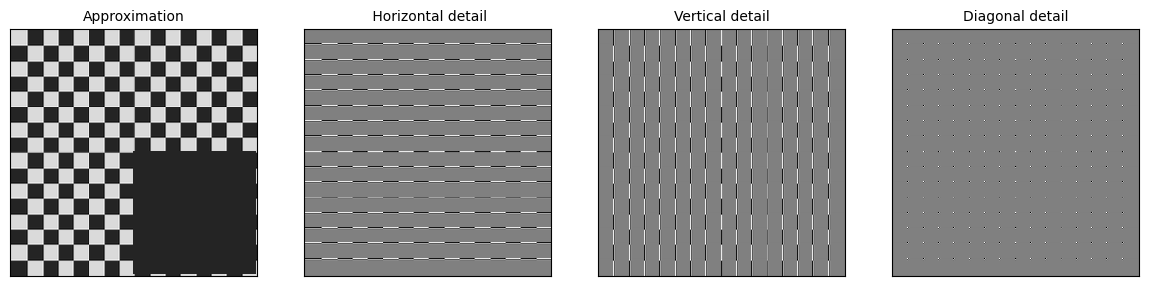

In [155]:
LL, (LH, HL, HH) = coeffs2
fig = plt.figure(figsize=(12, 3))
titles = ["Approximation", " Horizontal detail", "Vertical detail", "Diagonal detail"]
for i, a in enumerate([LL, LH, HL, HH]):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [156]:
I_d = pywt.idwt2(coeffs2, "db4")
fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray") he checkerboard image, try the Haar wavelet and compare the result with any other wavelet transform. What do you notice? Do you have an explan
plt.title("Before")
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_d, cmap="gray")
plt.title("After")
# plt.colorbar()
plt.show()

SyntaxError: invalid syntax (445822280.py, line 4)

## Exercise 3 <a id="ex3"></a> [(&#8593;)](#content)
1. Take a look at the documentation of the `pywt.wavedec2` and `pywt.waverec2`. How are the wavelet coefficients organized (scale? orientation?)?
2. Play with wavelet filtering procedure described above by setting some sets of coefficients to zero (approximation or details of various orientations). Illustrate its result with the `chessboard.png` image.
3. Do the same with any gray level image of your choice (see `img` folder). 
4. Observe and comment.

<p style="color:rgb(137, 207, 240);">Your comments</p>

In [ ]:
# Your codes #

---
## Wavelet Denoising <a id="section4"></a> [(&#8593;)](#content)

Wavelets are suitable for denoising signals which contain fast transients. In this context, thresholding can be used to cancel out the wavelet coefficients corresponding to regions where the signal varies smoothly. In these regions, the coefficients are expected to remain small (denoising is then provided by the low-pass cascade), and large wavelet coefficients (corresponding to large and fast transients of the signal) are preserved.

Let's simulate a noisy image to test the denoising procedure described above.

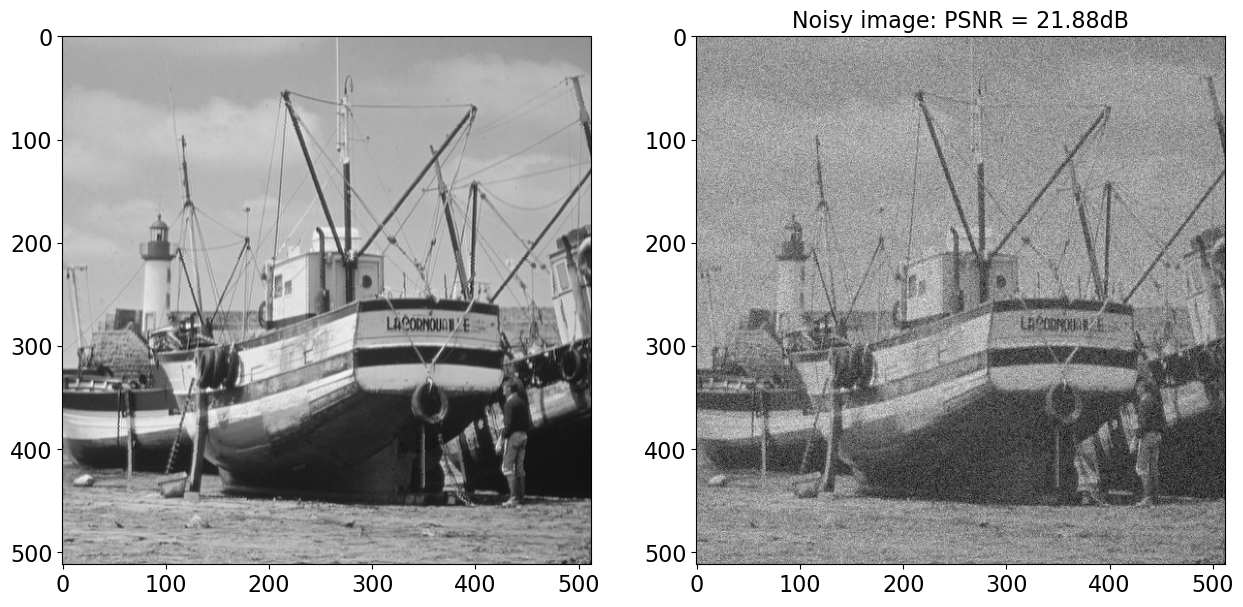

In [136]:
# The original image
filename = "img/boat.png"
I = mpimg.imread(filename)

# The noise
sigma = 0.1  # noise level

[n, m] = I.shape

# Simulating normalized Gaussian random variables
rng = np.random.default_rng(1234)
noise = rng.standard_normal(size=(m, n)) * sigma

# The noisy image
I_noisy = I + noise

# The PSNR quantifies the level of noise (see below for more explanations)
psnr1 = psnr(I, I_noisy, vmax=-1)


# Graphical representation
fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(I, cmap="gray")
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_noisy, cmap="gray")
plt.title("Noisy image: PSNR = {0:2.2f}dB".format(psnr1))
# plt.colorbar()
plt.show()

#### Peak signal-to-noise ratio: definition
The peak signal-to-noise ratio (PSNR) is defined as the ratio between the maximum possible power of a signal and the power of the noise that affecting its representation. Since many signals have a very wide dynamic range, the PSNR is usually expressed in decibel scale (dB).

The PSNR is usually defined via the mean squared error (MSE). Given a noise-free $m \times n$ monochromatic image $I$ and its noisy approximation $K$, the MSE is defined as:

$$\mathrm{MSE} = \frac{1}{m\,n}\sum_{i=0}^{m-1}\sum_{j=0}^{n-1} [I(i,j) - K(i,j)]^2 = \frac{1}{m\,n} \|I - K \|^2_{\text{F}}.$$

The PSNR in decibel (dB) is defined as:

\begin{align}
\mathrm{PSNR} &= 10 \log_{10} \left( \frac{\mathrm{MAX}_I^2}{\mathrm{MSE}} \right)\\ 
    &= 20 \log_{10} \left( {\mathrm{MAX}_I} \right) - 10 \log_{10} \left( {{\mathrm{MSE}}} \right)
\end{align}

where $\mathrm{MAX}_I$ corresponds to the maximum possible value taken by a pixel of the image. When the pixels are represented using 8 bits per sample, this is 255. The lower the error, the higher the PSNR.

**Extension to color images**: for color images, with containing three values per pixel (RGB representation), the definition of the PSNR is the similar, except the MSE is the sum over all squared value differences (for each color, i.e. three times as many values as in a monochromatic image) divided by 3 times the image size. 

### Thresholding
You can either use the `pywt.threshold` function, or a custom function as implemented below:

In [137]:
def perform_hardthresholding(f, thres):
    return f * (np.abs(f) > thres)

In [138]:
# Wavelet decomposition
Jmax = int(np.log2(I_noisy.shape[0]))  # maximal number of octaves
J = 5

coeffs = pywt.wavedec2(I_noisy, wavelet="sym8", level=J, mode="periodization")

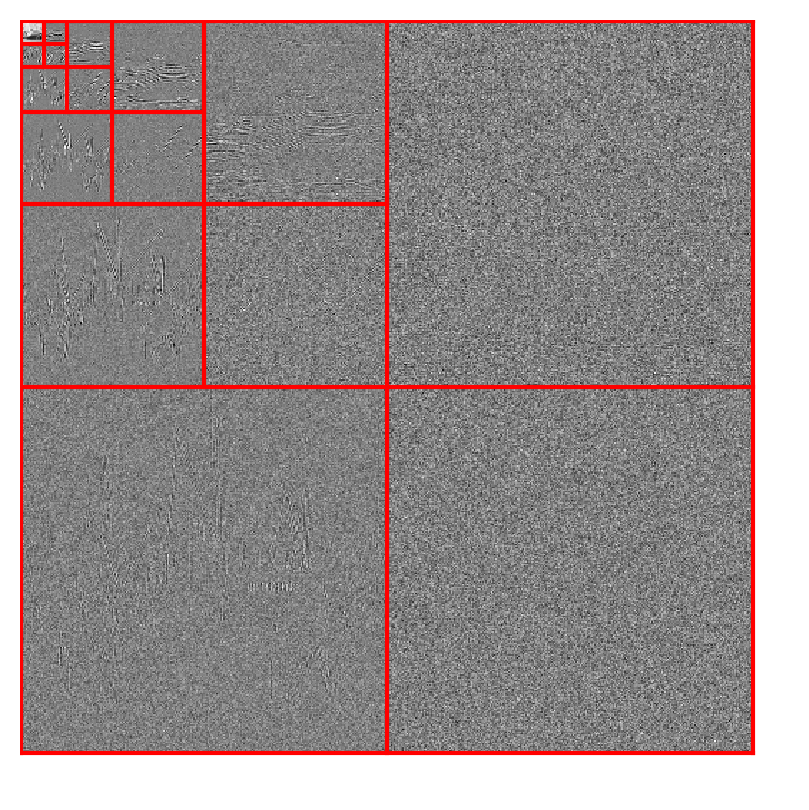

In [139]:
# Conversion to an array for graphical representation
coeffs_array, coeff_slices = pywt.coeffs_to_array(coeffs)

plt.figure(figsize=(5, 5), dpi=200)
plot_wavelet(coeffs_array, Jmin=Jmax - J)
plt.show()

In the following, we will keep the approximation coefficients unchanged, and only threshold details coefficients. Futher indications are provided below.

In [140]:
# Thresholding detail coefficients only (while preserving approximation coefficients)
# 1) threshold all coefficients stored in an array
# 2) reset approx coefficients to their original value

thres = 2.0 * sigma
coeffs_arr_hard = perform_hardthresholding(coeffs_array, thres)

In [141]:
# convert the array of coeffcients to pywt coeffs
coeffs_hard = pywt.array_to_coeffs(coeffs_arr_hard, coeff_slices)

# Setting original approximation coefficients back
coeffs_hard[0] = coeffs[0]  # approximation preserved

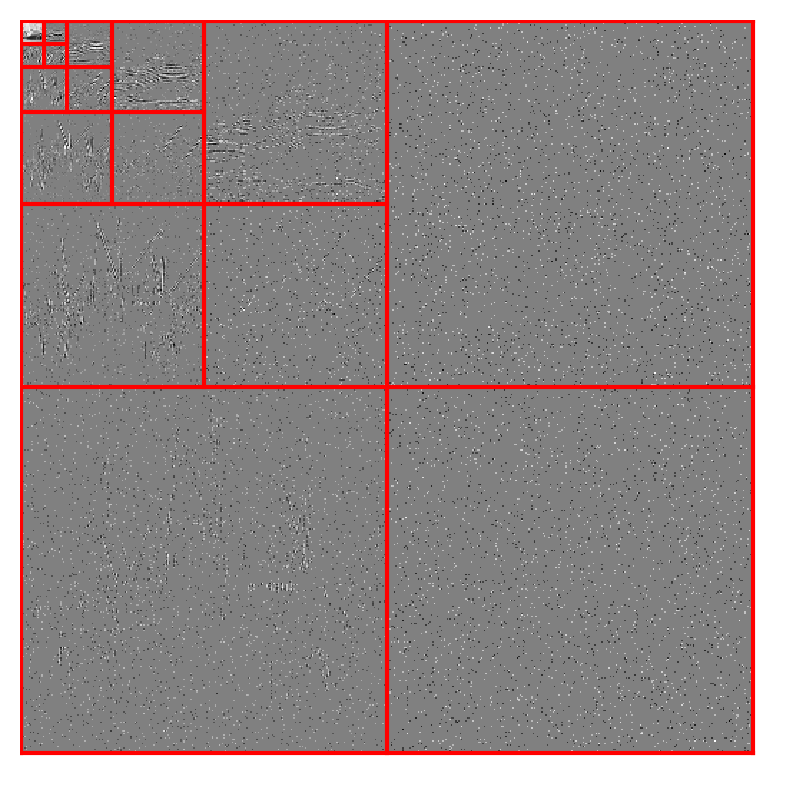

In [142]:
# Back to an array for graphical representation
coeffs_hard_arr, slices = pywt.coeffs_to_array(coeffs_hard)

plt.figure(figsize=(5, 5), dpi=200)
plot_wavelet(coeffs_hard_arr, Jmin=Jmax - J)
plt.show()

#### Reconstruction 

In [157]:
# Multilevel n-dimensional Inverse Discrete Wavelet Transform
I_den = pywt.waverecn(coeffs_hard, "sym8", mode="periodization")

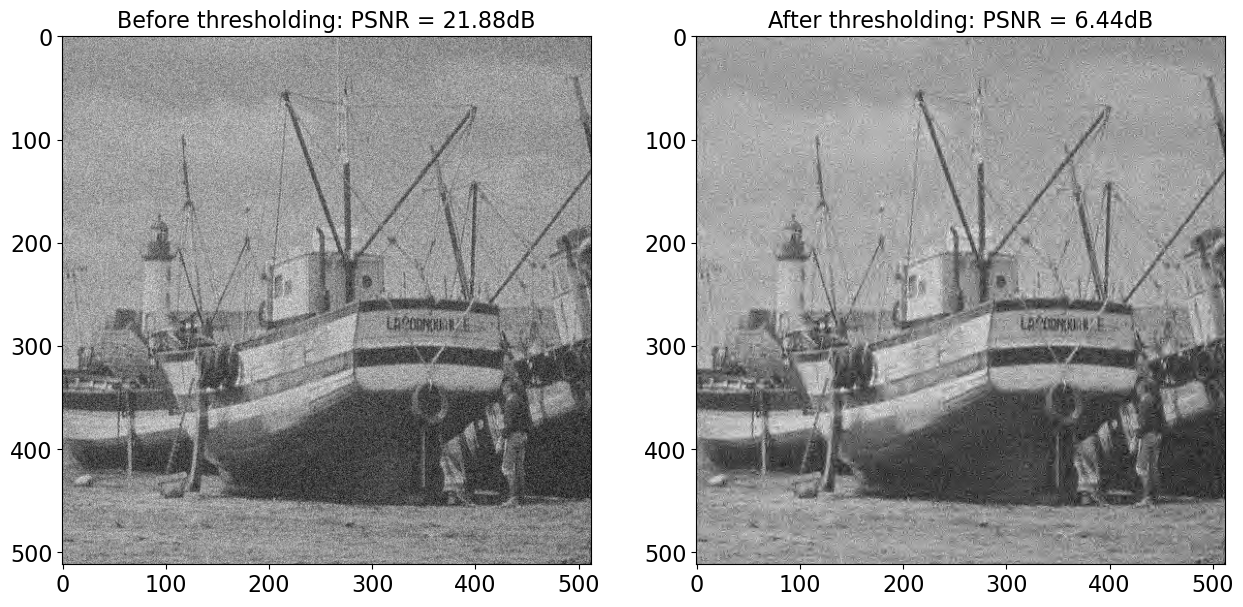

In [158]:
psnr2 = psnr(I, I_den, vmax=-1)
fig = plt.figure(figsize=(15, 7))
plt.subplot(121)
plt.imshow(I_noisy, cmap="gray")
plt.title("Before thresholding: PSNR = {0:2.2f}dB".format(psnr1))
# plt.colorbar()
plt.subplot(122)
plt.imshow(I_den, cmap="gray")
plt.title("After thresholding: PSNR = {0:2.2f}dB".format(psnr2))
# plt.colorbar()
plt.show()

### Exercise 4 <a id="ex4"></a> [(&#8593;)](#content)
1. Observe the effect of the level of the decomposition and of the threshold.
2. Optimize the parameters of your wavelet denoising strategy to get the best possible PSNR. 

<p style="color:rgb(137, 207, 240);">Your comments</p>

In [ ]:
# Your codes #

### Bonus: Exercise 5 <a id="ex5"></a> [(&#8593;)](#content)
Optimize your denoising strategy by using a translation invariant wavelet transform provided by `pywt.swt2` (stationary wavelet transform).

> Note: 
>
> - there is currently an issue in the documentation of the `pywt.swt2` function: use the `trim_approx=True` argument to obtain the same output format as the `pywt.wavedec2` function.
> - due to differences of `pywt.swt2` with respect to `pywt.wavedec2`, the `plot_wavelet` function above will not work as expected. You can directly display the array given by the `pywt.coeffs_to_array` function. Note however that the position of the vertical and horizontal details in this array are interverted compared to what is mentioned in the documentation (which can be seen by oberving the vertical and horizontal patterns, or by comparing with, e.g., the wavelet library in MATLAB).

<p style="color:rgb(137, 207, 240);">Your comments</p>

In [ ]:
# Your codes #